<a href="https://colab.research.google.com/github/ayoubbensakhria/finance_algo/blob/master/VIX_futures_term_struct_trading_strategy_WQU690_Capstone_Experiment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Strategy Overview

We will use VIX futures term-structure historical data (from 1/3/2016 to 8/4/2022), SPX/IXIC convergence/divergence using MACD to train a Random decision trees model to predict next IXIC movement.

## 1.1. Steps
1.   Download VIX futures term-structure historical data (CBOE)
2.   Download S&P500 index (SPX) and NASDAQ100 composite index (IXIC) historical data (Yahoo Finance)
3.   Compute technical indicators values for VIX, Contago, SPX/IXIC convergence/divergence
4.   Compute trading signals (target values -1 (sell), 0(no action), 1(buy)) for our learning process based on a predetermined risk:return ratio
5.   Use the computed values as features to train our model
6.   Crossvalidation, Performance report, Backtesting
7.   Deploy the model on real-time data



# 2. Install and import required libraries

In [2]:
# Yahoo finance data library
!pip install yfinance
# Technical indicators library
!pip install talib-binary

     |████████████████████████████████| 6.4 MB 7.3 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 2.4 MB 4.9 MB/s 


In [3]:
import math
import numpy as np
import pandas as pd
import warnings
import yfinance as yf
import talib as tb
from datetime import date, timedelta, datetime
from dateutil import parser
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import export_text
from sklearn import tree, datasets
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (24, 12)
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

# 2. Download Data
## 2.1. VIX Futures Term Structure Historical Data

In [4]:
# Dates Setup
start_date = date(2016, 3, 1)
end_date = date(2022, 4, 8)

To calculate the current level of contango we use the following formula: 

\begin{equation}
\mathrm{Ct}_{\mathrm{M}_{\mathrm{i}}, \mathrm{M}_{\mathrm{i}+1}}=\frac{\left(\mathrm{FVIX}_{\mathrm{M}_{\mathrm{i}+1}}-\mathrm{FVIX}_{\mathrm{M}_{\mathrm{i}}}\right) \cdot 100}{\mathrm{FVIX}_{\mathrm{M}_{\mathrm{i}}}}
\end{equation}

Where:

- $\mathrm{Ct}_{\mathrm{M}_{\mathrm{j}}, \mathrm{M}_{\mathrm{i}+1}}$ is % Contango between month $\mathrm{M}_{\mathrm{i}+1}$ and month $\mathrm{M}_{\mathrm{i}}$ VIX Futures.
- $\mathrm{FVIX}_{\mathrm{M}_{\mathrm{i}+1}}$ and FVIX $\mathrm{M}_{\mathrm{i}}$ are VIX future values at month $\mathrm{M}_{\mathrm{i}+1}$ and $\mathrm{M}_{\mathrm{i}}$ respectively.



In [31]:
# Get VIX Futures Term Structure Historical Data
vix_futures_csv = 'https://raw.githubusercontent.com/ayoubbensakhria/wqu690/master/data/vix_futures.csv'
df = pd.read_csv(vix_futures_csv, parse_dates=True)
# reverse df
df = df[::-1]
# set df index
df.index = pd.to_datetime(df['Date']).dt.date
# Drop unwanted columns for the current Experiment
columns_drop = ['Date', 'VXX', 'M1 Weight', 'M2 Weight', 'Weighted M1 M2', 'HV5', 'HV10', 'HV20', 'HV30', 'HV60', 'VVIX', 'VXX Bias', 'VRP', 'VIX GEX']
df.drop(columns_drop, axis=1, inplace=True)
# rename VIX3M
df.rename(columns={"VIX3M": "M3"}, inplace=True)
# Get data between start & end dates
mask = (df.index >= start_date) & (df.index< end_date)
df = df[mask]
# Compute Contango values
df['contango_m1'] = (df['M1'] - df['VIX'])*100/df['VIX']
df['contango_m2'] = (df['M2'] - df['M1'])*100/df['M1']
df['contango_m3'] = (df['M3'] - df['M2'])*100/df['M2']
df.head()

,VIX,M1,M2,M3,SPX,contango_m1,contango_m2,contango_m3
Date,,,,,,,,
2016-03-01,17.70,19.40,20.30,20.28,1978.35,9.604520,4.639175,-0.098522
2016-03-02,17.09,19.30,20.25,19.92,1986.45,12.931539,4.922280,-1.629630
2016-03-03,16.70,18.35,19.50,19.49,1993.40,9.880240,6.267030,-0.051282
2016-03-04,16.86,18.95,20.00,19.63,1999.99,12.396204,5.540897,-1.850000
2016-03-07,17.35,18.60,19.80,19.90,2001.76,7.204611,6.451613,0.505051


## 2.2. Download IXIC Historical Data and Join Dataframes

In [32]:
ixic = yf.download(tickers='^IXIC', start=start_date, end=end_date, interval="1d")
columns_drop = ['Close', 'High', 'Low', 'Open', 'Volume']
ixic.drop(columns_drop, axis=1, inplace=True)
# rename IXIC
ixic.rename(columns={"Adj Close": "IXIC"}, inplace=True)
# Join df on the left of IXIC
df = df.join(ixic)
df.head()

[*********************100%***********************]  1 of 1 completed


,VIX,M1,M2,M3,SPX,contango_m1,contango_m2,contango_m3,IXIC
Date,,,,,,,,,
2016-03-01,17.70,19.40,20.30,20.28,1978.35,9.604520,4.639175,-0.098522,4689.600098
2016-03-02,17.09,19.30,20.25,19.92,1986.45,12.931539,4.922280,-1.629630,4703.419922
2016-03-03,16.70,18.35,19.50,19.49,1993.40,9.880240,6.267030,-0.051282,4707.419922
2016-03-04,16.86,18.95,20.00,19.63,1999.99,12.396204,5.540897,-1.850000,4717.020020
2016-03-07,17.35,18.60,19.80,19.90,2001.76,7.204611,6.451613,0.505051,4708.250000


# 3. Compute Moving average convergence divergence (MACD) for SPX and IXIC 

MACD, short for moving average convergence/divergence, is a trading indicator used in technical analysis of stock prices.

MACD tells us about the convergence and divergence of the two moving averages. Convergence occurs when the moving averages move towards each other. Divergence occurs when the moving averages move away from each other.

In [33]:
df['spx_macd'], df['spx_signal'], df['spx_hist'] = tb.MACDFIX(df['SPX'])
df['ixic_macd'], df['ixic_signal'], df['ixic_hist'] = tb.MACDFIX(df['IXIC'])
df.tail()

,VIX,M1,M2,M3,SPX,contango_m1,contango_m2,contango_m3,IXIC,spx_macd,spx_signal,spx_hist,ixic_macd,ixic_signal,ixic_hist
Date,,,,,,,,,,,,,,,
2022-04-01,19.63,22.50,24.40,24.21,4545.8599,14.620479,8.444444,-0.778689,14261.500000,51.238860,30.401154,20.837706,188.036836,92.137100,95.899736
2022-04-04,18.57,21.00,23.21,23.03,4582.6401,13.085622,10.523810,-0.775528,14532.549805,53.097230,34.940369,18.156862,207.333537,115.176388,92.157150
2022-04-05,21.03,22.85,24.55,24.90,4525.1201,8.654303,7.439825,1.425662,14204.169922,49.647031,37.881701,11.765329,195.544575,131.250025,64.294550
2022-04-06,22.10,23.95,25.53,25.80,4481.1499,8.371041,6.597077,1.057579,13888.820312,43.078017,38.920964,4.157052,160.424406,137.084901,23.339505
2022-04-07,21.55,22.72,24.62,25.23,4500.2100,5.429234,8.362676,2.477660,13897.299805,38.858010,38.908373,-0.050364,131.642361,135.996393,-4.354032


## 2.3. Plot data

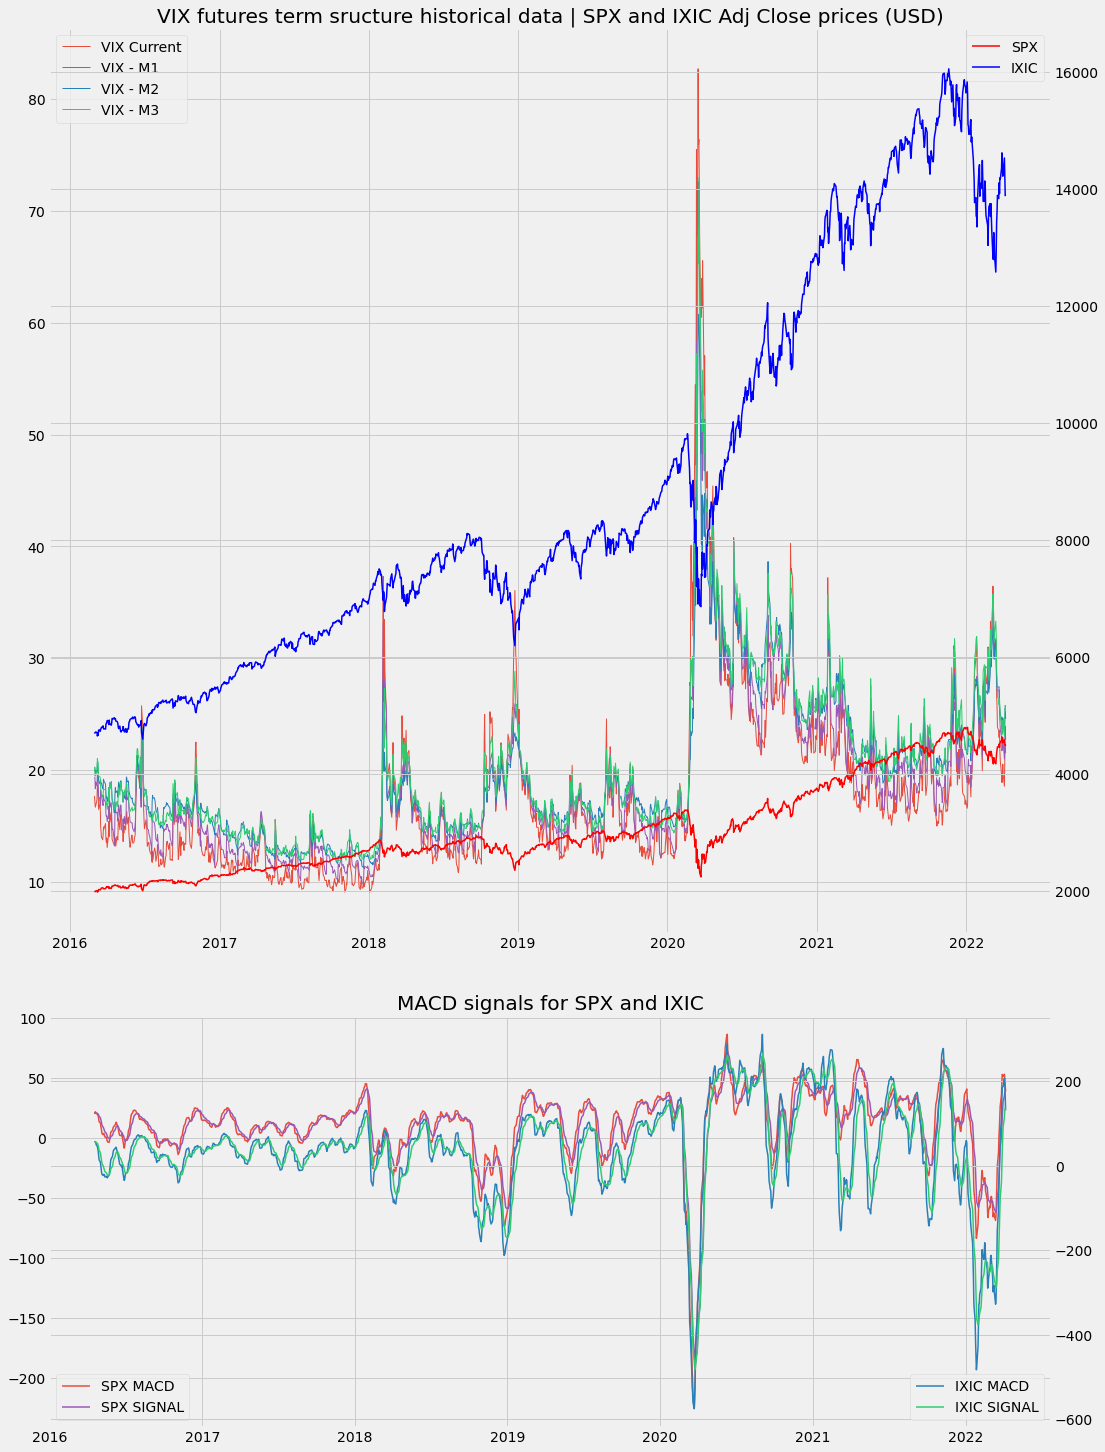

In [43]:
# Info: (x1, y1), (x2, y2)
# x1: number of rows, y1: number of columns 
# x2: row number, y2: column number
# documentation -> https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.subplot2grid.html
# Axe VIX with M1, M2, M3 maturities
plt.figure(figsize=(16,24))
vix_values = plt.subplot2grid((3, 1), (0,0),  colspan = 1, rowspan = 2)
vix_values.plot(df['VIX'], color = '#E74C3C', linewidth = 1,  label = 'VIX Current')
vix_values.plot(df['M1'], color = '#9B59B6', linewidth = 1, label = 'VIX - M1')
vix_values.plot(df['M2'], color = '#2980B9', linewidth = 1, label = 'VIX - M2')
vix_values.plot(df['M3'], color = '#2ECC71', linewidth = 1,  label = 'VIX - M3')
plt.legend(loc = 'upper left')

# Axe prices: SPX and IXIC Close Prices
axe_prices = vix_values.twinx()
axe_prices.plot(df['SPX'], color = 'red', linewidth = 1.5, label = 'SPX')
axe_prices.plot(df['IXIC'], color = 'blue', linewidth = 1.5, label = 'IXIC')
# add titles to subplots
axe_prices.set_title('VIX futures term sructure historical data | SPX and IXIC Adj Close prices (USD)')
# set legend position
plt.legend(loc = 'upper right')

# Plot MACD
axe_spx_macd = plt.subplot2grid((3, 1), (2,0),  colspan = 1)
axe_spx_macd.plot(df['spx_macd'], color = '#E74C3C', linewidth = 1.5, label = 'SPX MACD')
axe_spx_macd.plot(df['spx_signal'], color = '#9B59B6', linewidth = 1.5, label = 'SPX SIGNAL')
plt.legend(loc = 'lower left')
axe_ixic_macd = axe_spx_macd.twinx()
axe_ixic_macd.plot(df['ixic_macd'], color = '#2980B9', linewidth = 1.5, label = 'IXIC MACD')
axe_ixic_macd.plot(df['ixic_signal'], color = '#2ECC71', linewidth = 1.5, label = 'IXIC SIGNAL')
axe_ixic_macd.set_title('MACD signals for SPX and IXIC')
plt.legend(loc = 'lower right')
